In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import mplfinance as mpf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf
import statsmodels.api as sm
from sklearn.metrics import r2_score


2023-10-24 08:48:57.747208: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-24 08:48:58.061240: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-24 08:48:58.061296: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-24 08:48:58.062809: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-24 08:48:58.186534: I tensorflow/core/platform/cpu_feature_g

In [2]:
start = "2010-01-01"
end = "2020-12-31"

def read_dataset(filename):
    data = pd.read_csv(filename, index_col=0, parse_dates=True)
    return data.loc[start:end]


In [3]:
commodities = read_dataset('../data/commodities.csv')
company = read_dataset('../data/company.csv')
fixed_income = read_dataset('../data/fixed_income.csv')
forex = read_dataset('../data/forex.csv')
GS = read_dataset('../data/GS.csv')
us_macro = read_dataset('../data/us_macro.csv')

In [ ]:
def plot_stock(stock):
    fig, axes = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={'height_ratios': [2, 1]})
    
    mpf.plot(stock, 
             type='candle', 
             ax=axes[0], 
             volume=axes[1], 
             show_nontrading=True, 
             title='Goldman Sachs Stock Price',
             figratio=(10,6))

    axes[0].set_ylabel('Price')
    axes[1].set_ylabel('Volume')

    plt.tight_layout()
    plt.show()

In [ ]:
plot_stock(GS)

In [4]:
def evaluate_prediction_power(target_series, predictor_series):
    # Ensure the indices are datetime objects and the series are aligned by date
    target_series.index = pd.to_datetime(target_series.index)
    predictor_series.index = pd.to_datetime(predictor_series.index)
    merged_data = pd.merge(target_series, predictor_series, left_index=True, right_index=True)
    
    # Drop rows with missing or infinite values
    merged_data = merged_data.dropna().replace([np.inf, -np.inf], np.nan).dropna()

    # Perform linear regression
    X = merged_data.iloc[:, 1]  # Predictor Series
    y = merged_data.iloc[:, 0]  # Target Series
    X = sm.add_constant(X)  # Adds a constant term to the predictor

    model = sm.OLS(y, X)
    results = model.fit()

    # Evaluate the model
    predictions = results.predict(X)
    r_squared = r2_score(y, predictions)
    
    return r_squared, results.summary()

def get_top_five(dataframe, target_series):
    results_list = []
    for column in dataframe.columns:
        predictor_series = dataframe[column]
        r_squared, summary = evaluate_prediction_power(target_series, predictor_series)
        results_list.append((column, r_squared))
    sorted_results = sorted(results_list, key=lambda x: x[1], reverse=True)
    top_5_columns = [item[0] for item in sorted_results[:5]]
    return dataframe[top_5_columns]

In [5]:
top_commodities = get_top_five(commodities, GS['Adj Close'])
# top_company = get_top_five(company, GS['Adj Close'])
top_fixed_income = get_top_five(fixed_income, GS['Adj Close'])
top_forex = get_top_five(forex, GS['Adj Close'])

best_data = pd.concat([top_commodities, top_fixed_income, top_forex, us_macro, GS], axis=1)

In [6]:
best_data.replace([np.inf, -np.inf], np.nan, inplace=True)
best_data.fillna(method='bfill', inplace=True)
best_data.fillna(method='ffill', inplace=True)

/tmp/ipykernel_4632/2475427688.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  best_data.fillna(method='bfill', inplace=True)
/tmp/ipykernel_4632/2475427688.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  best_data.fillna(method='ffill', inplace=True)


In [7]:
train_size = int(len(best_data)*0.67)
test_size = len(best_data) - train_size
train, test = best_data[0:train_size], best_data[train_size:len(best_data)]
print(len(train), len(test))

2692 1326


In [17]:
features = train
target = train['Close'].shift(-1)  # Shift the target by one time step to forecast the next 'Close'

# Dropping NaN values from the last row
features = features.iloc[:-1]
target = target.iloc[:-1]

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))

# Splitting the data into training and testing sets
train_size = int(len(features) * 0.67)
test_size = len(features) - train_size
train_features, test_features = features_scaled[0:train_size, :], features_scaled[train_size:len(features), :]
train_target, test_target = target_scaled[0:train_size, :], target_scaled[train_size:len(features), :]

# Reshape input to be [samples, time steps, features]
train_features = np.reshape(train_features, (train_features.shape[0], 1, train_features.shape[1]))
test_features = np.reshape(test_features, (test_features.shape[0], 1, test_features.shape[1]))


# Define the LSTM model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(150, input_shape=(train_features.shape[1], train_features.shape[2])),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_features, train_target, epochs=20, batch_size=10, verbose=2)

# Making predictions
train_predict = model.predict(train_features)
test_predict = model.predict(test_features)

# Inverting the predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
train_target = scaler.inverse_transform(train_target)
test_predict = scaler.inverse_transform(test_predict)
test_target = scaler.inverse_transform(test_target)

Epoch 1/20


/usr/lib/python3/dist-packages/sklearn/utils/validation.py:507: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  array.dtypes.apply(is_sparse).any()):
/usr/lib/python3/dist-packages/sklearn/utils/validation.py:507: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  array.dtypes.apply(is_sparse).any()):


181/181 - 1s - loss: 0.0062 - 1s/epoch - 8ms/step
Epoch 2/20
181/181 - 0s - loss: 3.3684e-04 - 298ms/epoch - 2ms/step
Epoch 3/20
181/181 - 0s - loss: 2.4342e-04 - 270ms/epoch - 1ms/step
Epoch 4/20
181/181 - 0s - loss: 2.3414e-04 - 272ms/epoch - 2ms/step
Epoch 5/20
181/181 - 0s - loss: 1.9942e-04 - 291ms/epoch - 2ms/step
Epoch 6/20
181/181 - 0s - loss: 2.1411e-04 - 279ms/epoch - 2ms/step
Epoch 7/20
181/181 - 0s - loss: 2.1978e-04 - 299ms/epoch - 2ms/step
Epoch 8/20
181/181 - 0s - loss: 2.2946e-04 - 286ms/epoch - 2ms/step
Epoch 9/20
181/181 - 0s - loss: 2.3864e-04 - 273ms/epoch - 2ms/step
Epoch 10/20
181/181 - 0s - loss: 2.2578e-04 - 273ms/epoch - 2ms/step
Epoch 11/20
181/181 - 0s - loss: 2.2887e-04 - 285ms/epoch - 2ms/step
Epoch 12/20
181/181 - 0s - loss: 2.1065e-04 - 308ms/epoch - 2ms/step
Epoch 13/20
181/181 - 0s - loss: 2.2044e-04 - 328ms/epoch - 2ms/step
Epoch 14/20
181/181 - 0s - loss: 2.0018e-04 - 288ms/epoch - 2ms/step
Epoch 15/20
181/181 - 0s - loss: 2.1169e-04 - 291ms/epoch - 2

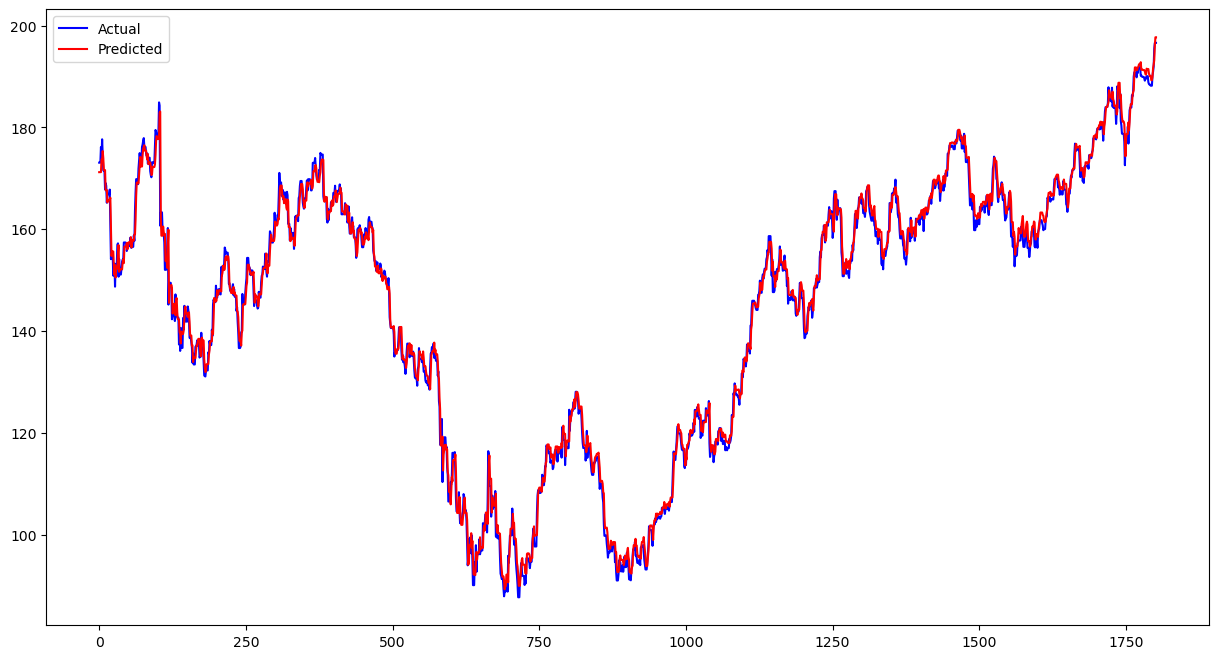

In [18]:
# Plotting the actual and predicted values
plt.figure(figsize=(15,8))
plt.plot(train_target, color='blue')
plt.plot(train_predict, color='red')
plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.show()

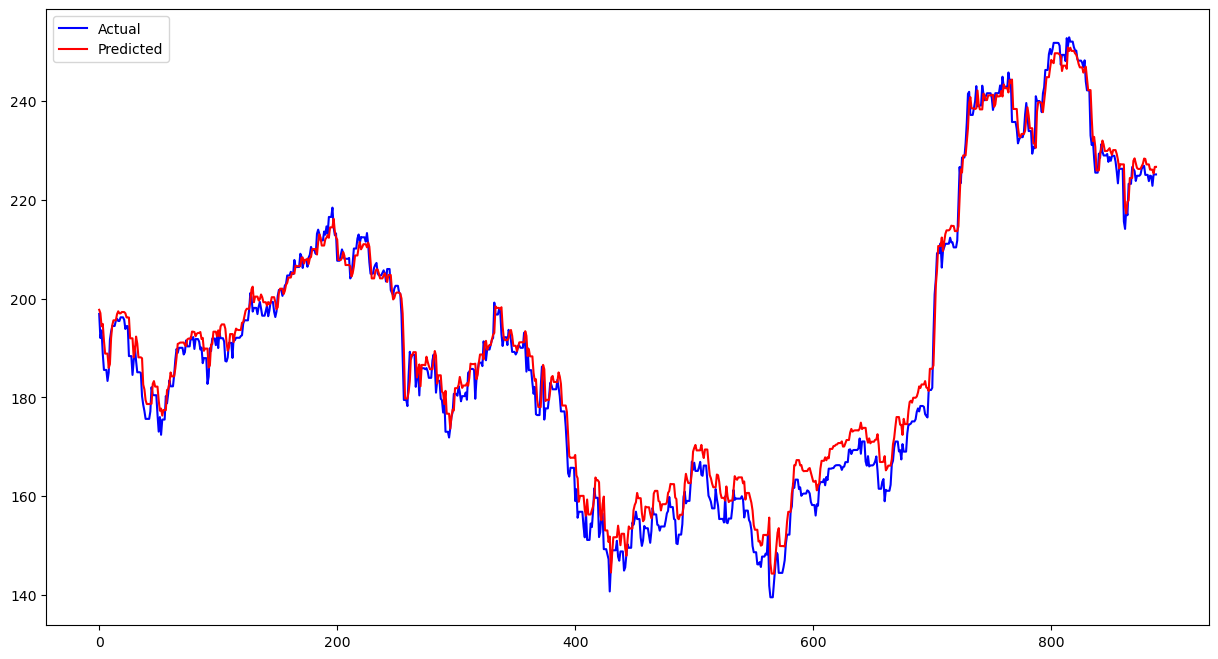

In [19]:
plt.figure(figsize=(15,8))
plt.plot(test_target, color='blue')
plt.plot(test_predict, color='red')
plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.show()